In [121]:
# Author : Paul-Antoine Nguyen
# This script was edited by hayato tominaga.

# This script considers all the products a user has ordered
# We train a model computing the probability of reorder on the "train" data
# For the submission, we keep the orders that have a probability of
# reorder higher than a threshold
# some overhead because of kernel memory limits


In [2]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns',10000); pd.set_option('display.max_rows', 50); np.set_printoptions(threshold=90000)

import lightgbm as lgb
import gc
IDIR = '../../../../input/'
IDIR2 = '../../../../input/rawpkl/'

priors = pd.read_pickle(IDIR2 + 'order_products__prior.pkl')
train = pd.read_pickle(IDIR2 + 'order_products__train.pkl')
orders = pd.read_pickle(IDIR2 + 'orders.pkl')
products = pd.read_pickle(IDIR2 + 'products.pkl')

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}:    {}'.format(train.shape, ', '.join(train.columns)))

priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4):    order_id, product_id, add_to_cart_order, reordered


In [3]:
'''このセルは全部メモリ対策 https://qiita.com/ssl_ds_sps/items/6afb3043d97ee7635992'''
orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)

products.drop(['product_name'], axis=1, inplace=True)
products.aisle_id = products.aisle_id.astype(np.int8)
products.department_id = products.department_id.astype(np.int8)
products.product_id = products.product_id.astype(np.int32)

train.reordered = train.reordered.astype(np.int8)
train.add_to_cart_order = train.add_to_cart_order.astype(np.int16)


priors.order_id = priors.order_id.astype(np.int32)
priors.add_to_cart_order = priors.add_to_cart_order.astype(np.int16)
priors.reordered = priors.reordered.astype(np.int8)
priors.product_id = priors.product_id.astype(np.int32)

In [4]:
'''
商品IDベースの特徴量*3を作りproductテーブルにjoin
- 注文回数
- そのうちの再注文回数
- 注文回数/再注文回数
'''
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.float32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

'''priorsにorder情報をjoin'''
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

add order info to priors


In [5]:
### user features
'''ユーザベース特徴量
usr['average_days_between_orders'] 注文間隔の平均
usr['nb_orders'] 注文数

users['total_items'] 重複ありでの総購入商品数
users['all_products'] user_idごとの商品IDの集合=注文したことがある全商品 
users['total_distinct_items'] users['all_products']の数(長さ)

users['average_basket'] 1回当たり購入商品数
'''

'''order=注文ID単位'''
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

'''prior=注文IDの詳細な列単位'''
users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)

gc.collect() # メモリを開放するときに使う。乱発するとアカンらしい
print('user table shape', users.shape)


user f (206209, 6)


In [6]:
'''

d.head()
{-1246903360: (5, (8, 104690), 10),…} 
               0        1       2
{特定ユーザ×特定商品ID}: (商品を購入した数, (一番新しい注文NO.と注文ID), 何番目にカートに入れたかの足し合わせ),…}

# ハッシュ値的なものを作ってそれごとに上の特徴量を作成、あとでマージしてハッシュ値は捨てる
'''

priors['user_product'] = priors.product_id + priors.user_id * 100000

# This was to slow !!
#def last_order(order_group):
#    ix = order_group.order_number.idxmax
#    return order_group.shape[0], order_group.order_id[ix],  order_group.add_to_cart_order.mean()
#userXproduct = pd.DataFrame()
#userXproduct['tmp'] = df.groupby('user_product').apply(last_order)

d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)
print('to dataframe (less memory)')
d = pd.DataFrame.from_dict(d, orient='index') # orient=向き、キーをインデックスに使うかカラムに使うか
d.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']

d.nb_orders = d.nb_orders.astype(np.int16)
d.last_order_id = d.last_order_id.map(lambda x: x[1]).astype(np.int32) # 一番新しい注文no.は使わないことを選択
d.sum_pos_in_cart = d.sum_pos_in_cart.astype(np.int16)
   
userXproduct = d
print('user X product f', len(userXproduct))

del priors


compute userXproduct f - this is long...


'\n{-1246903360: (5, (8, 104690), 10),…}\n               0        1       2\n{特定ユーザ×特定商品ID}: (商品を購入した数, (一番新しい注文NO.と注文ID), 何番目にカートに入れたかの足し合わせ),…}\n\n'

In [10]:
userXproduct

,nb_orders,last_order_id,sum_pos_in_cart
-1246903360,5,104690,10
-1246907495,5,132412,16
-1246927153,1,2,3
-1246890562,5,2382766,24
-1246906445,3,2382766,14
...,...,...,...
-1770221987,1,3421083,2
-1770246134,1,3421083,3
-1770232085,1,3421083,5
-1770255944,1,3421083,7


In [11]:
### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)


split orders : train, test


In [12]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN
2398795,2398795,1,prior,2,3,7,15.0
473747,473747,1,prior,3,3,12,21.0
2254736,2254736,1,prior,4,4,7,29.0
431534,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
2266710,2266710,206209,prior,10,5,18,29.0
1854736,1854736,206209,prior,11,4,10,30.0
626363,626363,206209,prior,12,1,12,18.0


In [13]:
train_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0
...,...,...,...,...,...,...,...
2585586,2585586,206199,train,20,2,16,30.0
943915,943915,206200,train,24,6,19,6.0
2371631,2371631,206203,train,6,4,19,30.0


In [14]:
users

,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000
...,...,...,...,...,...,...
206205,32,"{20995, 21137, 22035, 21910, 17691, 31404, 210...",24,16.666666,4,8.000000
206206,285,"{16896, 44033, 18434, 16387, 21508, 45573, 102...",150,3.716418,68,4.191176
206207,223,"{20995, 18441, 45578, 47626, 33806, 22035, 235...",92,14.312500,17,13.117647


In [54]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    # print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%100000 == 0: print('order row',i)
        
        order_id = row.order_id
        user_id = row.user_id

        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        
        if labels_given:
            # index判定するためにマルチindex=Trueだった
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list})
    df.order_id = df.order_id.astype(np.int32);df.product_id = df.product_id.astype(np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    '''ユーザ関係の特徴量をくっつける''' 
    df['user_id'] = df.order_id.map(orders.user_id).astype(np.int32)
    # df.merge(orders['user_id'], on=inner, how='order_id')と同じことが上でできてるっぽい。
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    '''注文ID単位の特徴量をくっつける'''
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    '''商品ID単位の特徴量をくっつける'''
    df['aisle_id'] = df.product_id.map(products.aisle_id).astype(np.int8)
    df['department_id'] = df.product_id.map(products.department_id).astype(np.int8)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.float32)
    df['product_reorders'] = df.product_id.map(products.reorders).astype(np.float32)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32) # 平均購入個数
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - \
                  df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    # print(df.dtypes)
    # print(df.memory_usage())
    # print(train.memory_usage())
    # print(products.memory_usage())
    gc.collect()
    return (df, labels)
    

df_train, labels = features(train_orders, labels_given=True)


order row 100000
user_X_product related features


In [ ]:

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'



print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
# <lightgbm.basic.Dataset at 0x2440309e730>

# カーネル制約がないのでコメントアウトしておく
# del df_train
# gc.collect()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 98


formating for lgb


light GBM train :-)


C:\Users\hayatotominaga\anaconda3\envs\rake4\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 828824, number of negative: 7645837
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3279
[LightGBM] [Info] Number of data points in the train set: 8474661, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909


198

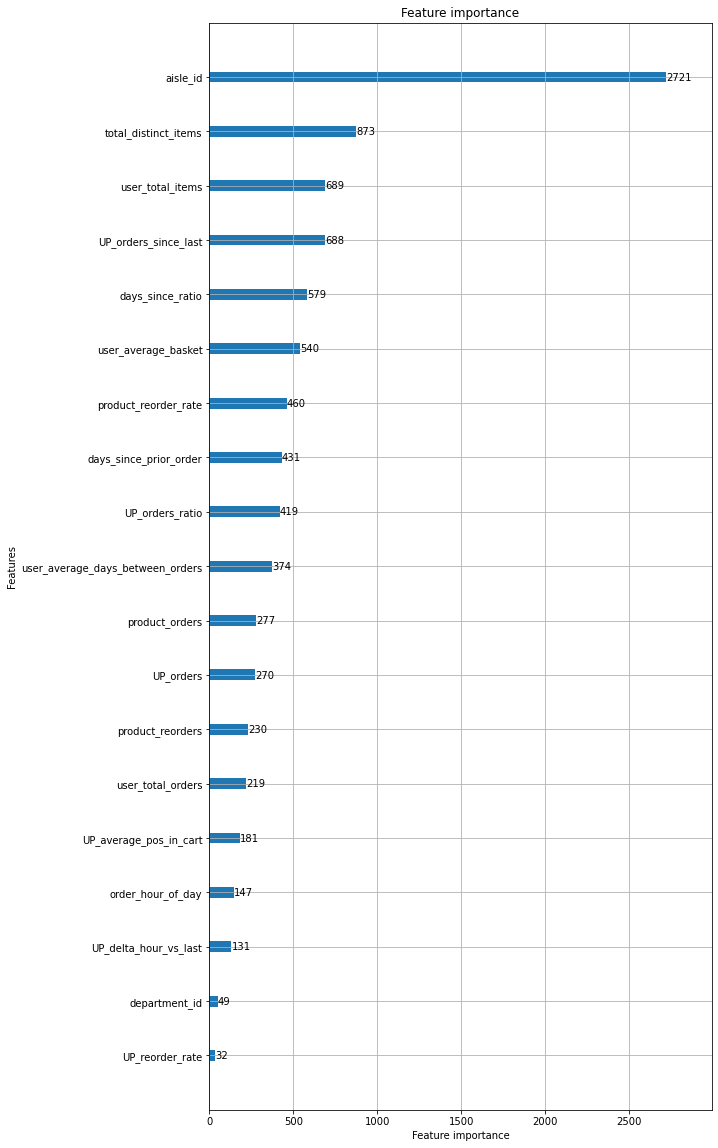

In [20]:
print('light GBM train :-)')
bst = lgb.train(params, d_train, num_boost_round=ROUNDS)
lgb.plot_importance(bst, figsize=(9,20))
del d_train
gc.collect()

In [ ]:
### build candidates list for test ###
df_test, _ = features(test_orders)

preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

In [25]:
df_test.sort_values('pred',ascending=False).head(50)

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,pred
673931,1352816,28842,9,141,78,15.875000,15.666667,10,0.0,0.000000,16,4,45530.0,25877.0,0.568351,3,0.333333,3.000000,0.333333,1,0,0.947827
2636996,1175088,34126,12,203,76,10.272727,16.916666,6,0.0,0.000000,16,4,60621.0,37141.0,0.612675,6,0.500000,10.000000,0.500000,1,0,0.944636
673969,1352816,5025,9,141,78,15.875000,15.666667,10,0.0,0.000000,83,4,26536.0,13787.0,0.519558,4,0.444444,8.500000,0.444444,1,0,0.942478
2342673,3278255,34243,20,154,52,16.000000,7.700000,5,0.0,0.000000,83,4,31792.0,20640.0,0.649220,4,0.200000,8.000000,0.200000,1,0,0.941778
2586755,396882,31981,17,200,61,19.250000,11.764706,10,0.0,0.000000,84,16,8621.0,6816.0,0.790628,16,0.941176,2.562500,0.941176,1,0,0.941172
2586719,396882,29487,17,200,61,19.250000,11.764706,10,0.0,0.000000,83,4,40212.0,25642.0,0.637670,16,0.941176,2.000000,0.941176,1,0,0.940449
2586751,396882,18659,17,200,61,19.250000,11.764706,10,0.0,0.000000,-128,3,993.0,430.0,0.433031,3,0.176471,12.666667,0.176471,1,0,0.940051
2561844,761064,196,19,29,5,7.611111,1.526316,17,7.0,0.919708,77,7,35791.0,27791.0,0.776480,18,0.947368,1.000000,0.947368,1,0,0.939198
1445489,736447,39180,44,191,11,8.488372,4.340909,12,9.0,1.060274,84,16,14869.0,12488.0,0.839868,43,0.977273,1.488372,0.977273,1,2,0.939054
2342644,3278255,17794,20,154,52,16.000000,7.700000,5,0.0,0.000000,83,4,72736.0,46572.0,0.640288,4,0.200000,10.750000,0.200000,1,0,0.939034


In [26]:
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

In [28]:
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('light_gbm_benchmark_0_3692_submit.csv', index=False)

In [149]:
sub

,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 17706 28465 27959 44632 24799 34658 1494...
3,1356845,11520 14992 7076 28134 10863 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839
...,...,...
74995,2498703,None
74996,2769683,None
74997,783264,None
74998,2994962,None
